In [8]:
from src import api
rslt = api.fmp_test()
rslt.display_figs()

Group optimization of 1 alphas , 3 benchmarks , 2 lags , 12 dates , (72 opts) start!
Done Optimize [factor1.csi300   ] at 20231201 , time cost (ms) : {'parse_input': 33.16, 'solve': 223.46, 'output': 21.94}
Done Optimize [factor1.csi500   ] at 20231201 , time cost (ms) : {'parse_input': 17.66, 'solve': 120.32, 'output': 31.24}
Done Optimize [factor1.csi1000  ] at 20231201 , time cost (ms) : {'parse_input': 23.64, 'solve': 105.32, 'output': 41.89}
Done Optimize [factor1.csi300.1 ] at 20231201 , time cost (ms) : {'parse_input': 36.22, 'solve': 130.8, 'output': 9.0}
Done Optimize [factor1.csi500.1 ] at 20231201 , time cost (ms) : {'parse_input': 31.24, 'solve': 129.25, 'output': 35.11}
Done Optimize [factor1.csi1000.1] at 20231201 , time cost (ms) : {'parse_input': 41.05, 'solve': 170.45, 'output': 37.56}
Done Optimize [factor1.csi300   ] at 20231208 , time cost (ms) : {'parse_input': 57.85, 'solve': 352.53, 'output': 41.25}
Done Optimize [factor1.csi500   ] at 20231208 , time cost (ms) :

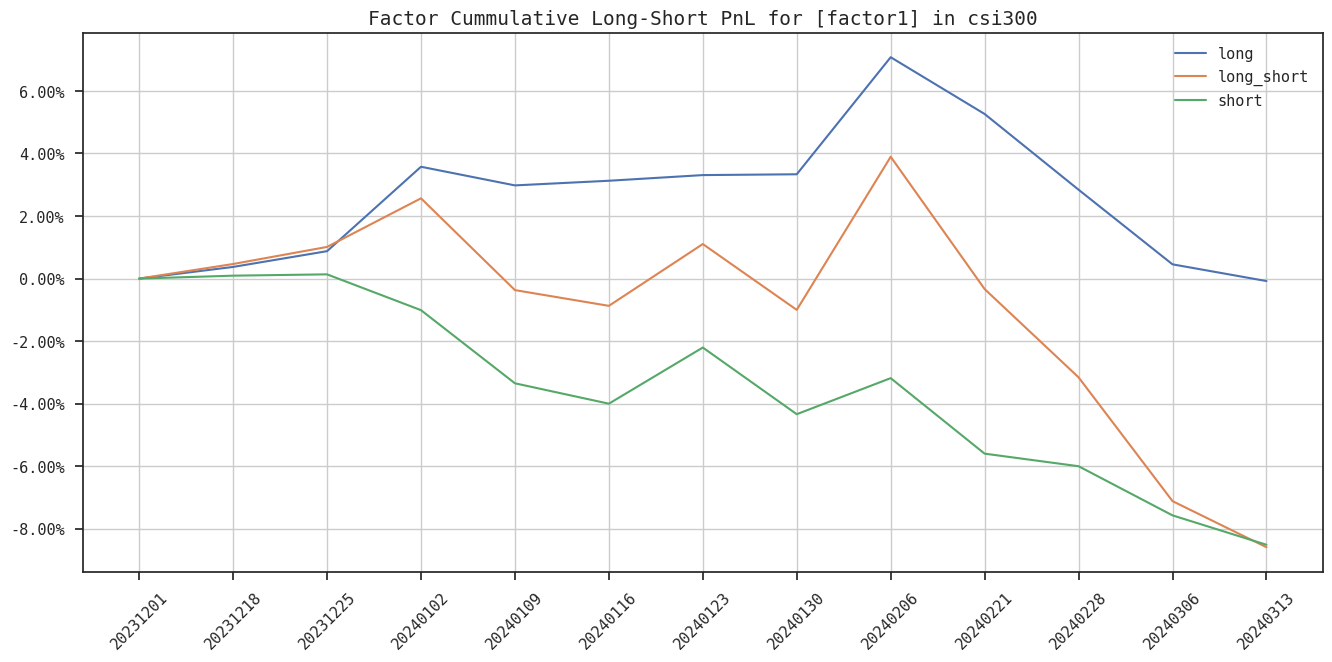

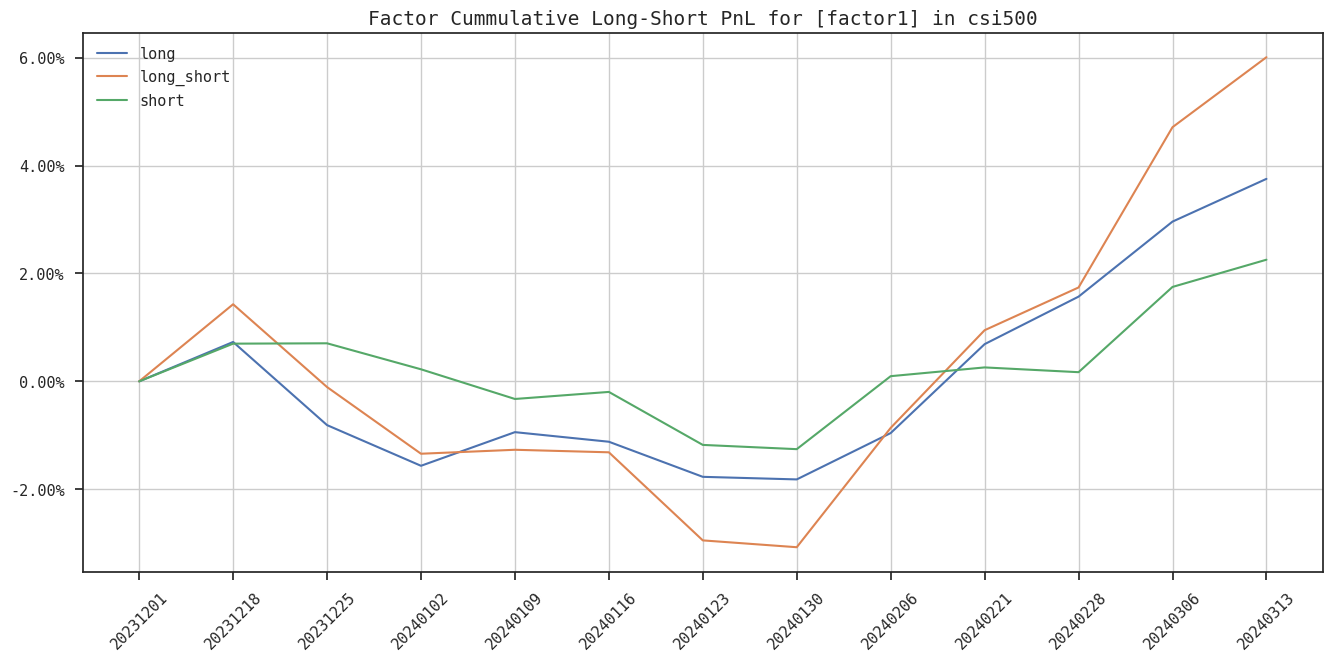

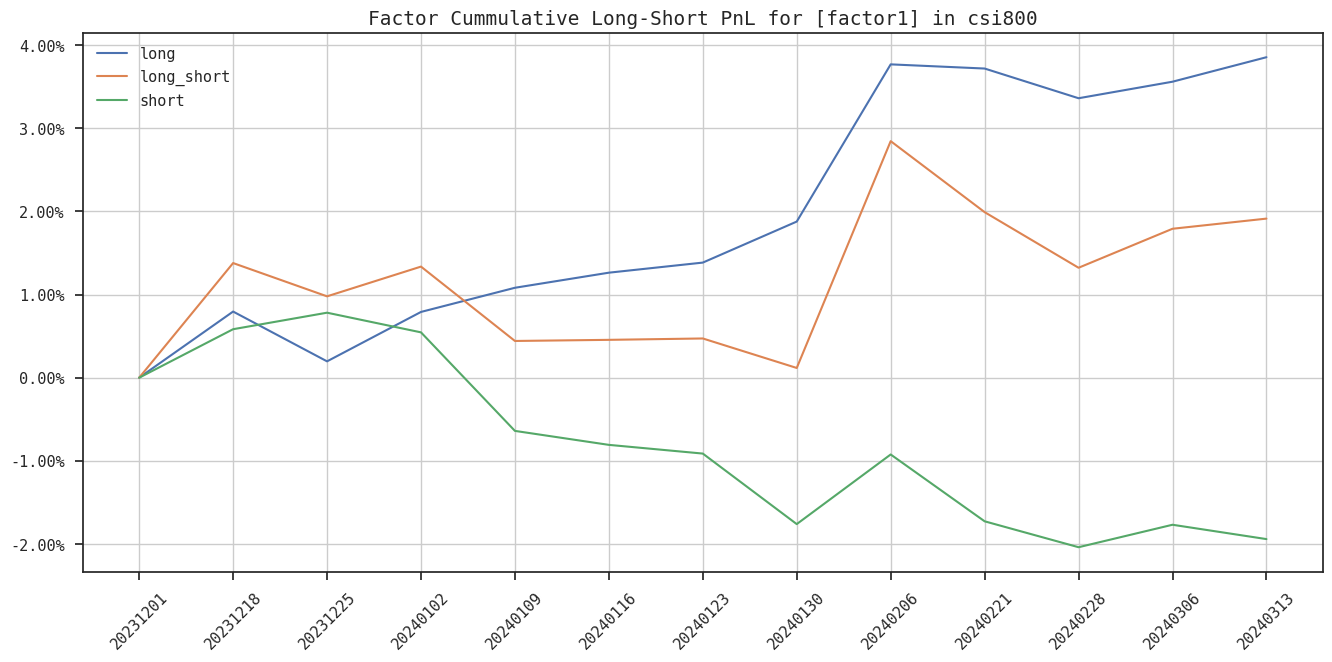

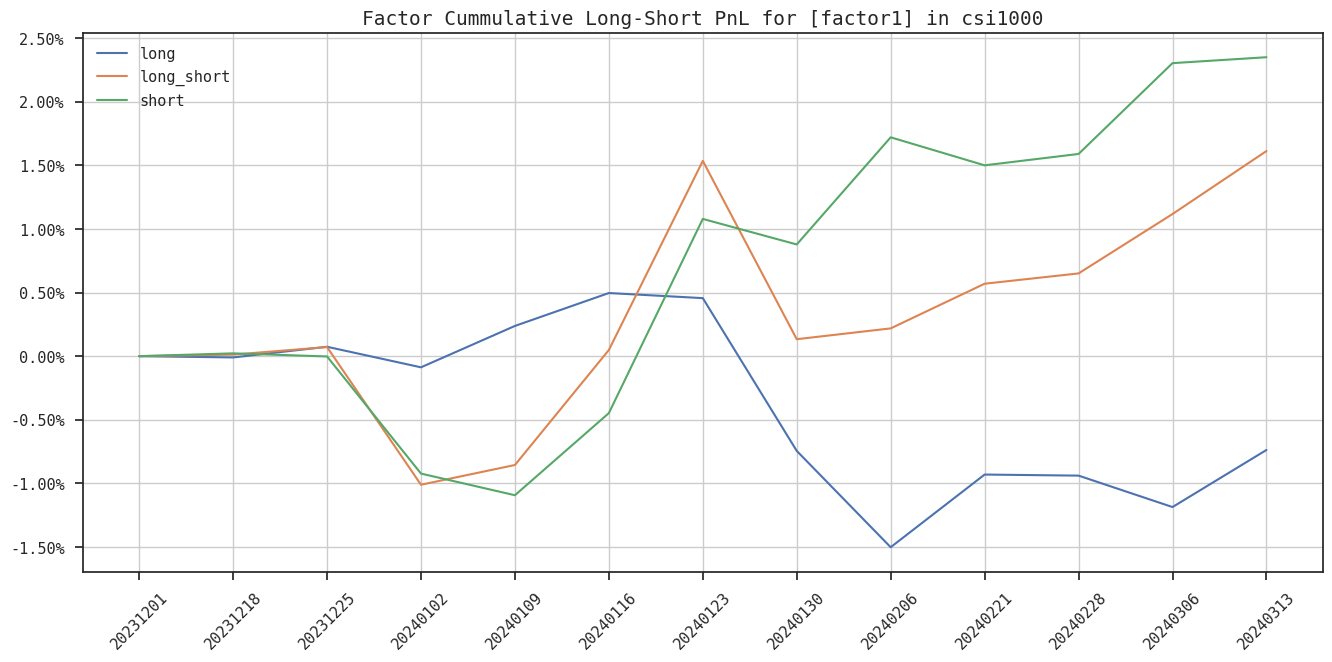

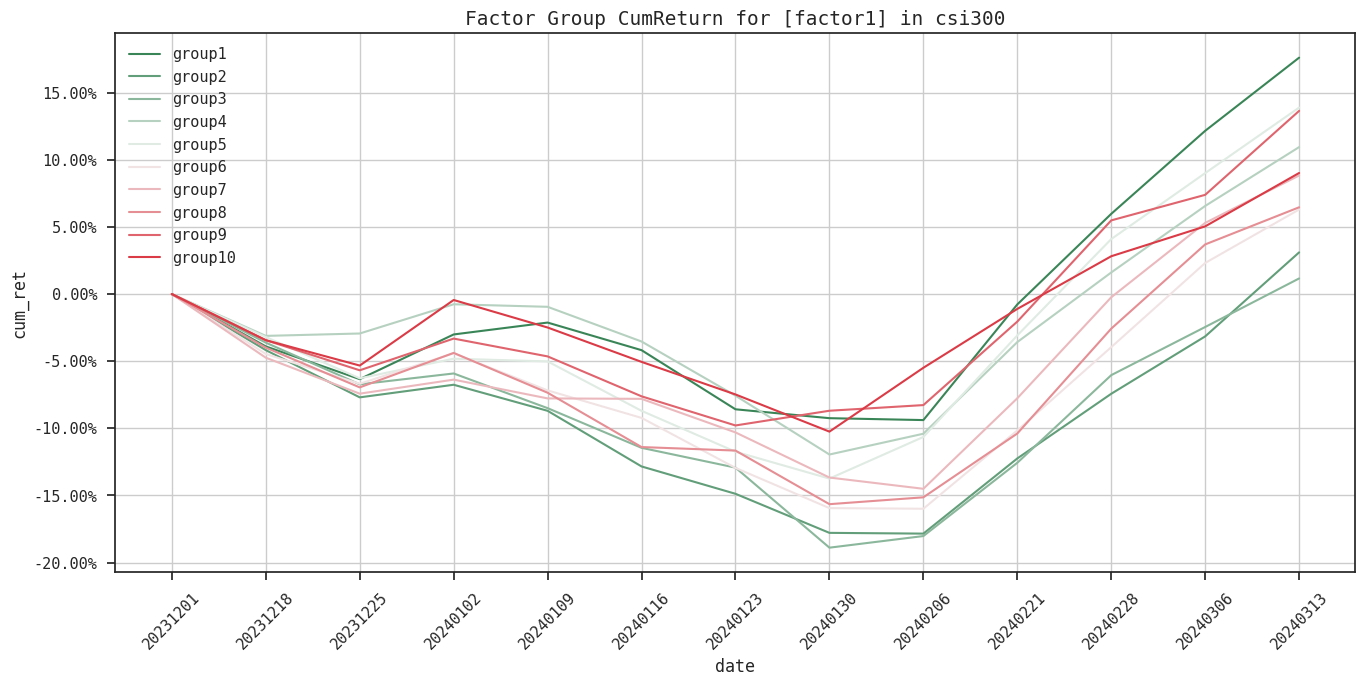

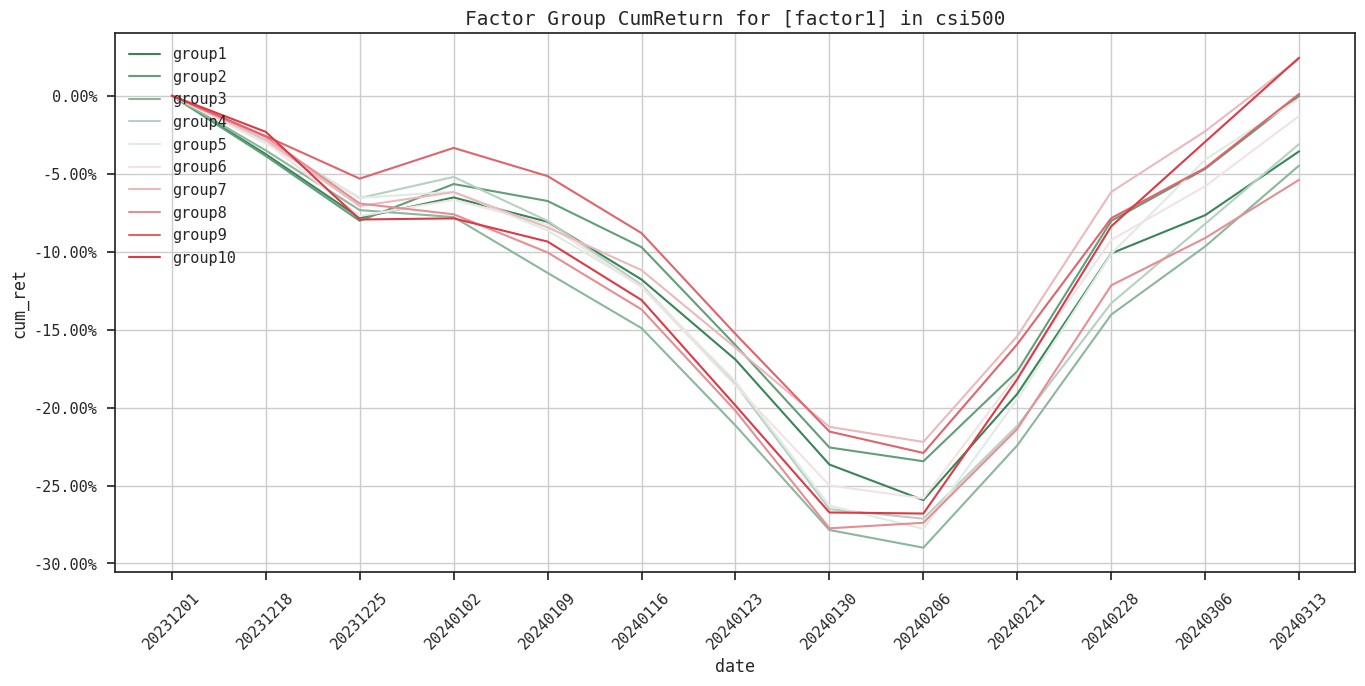

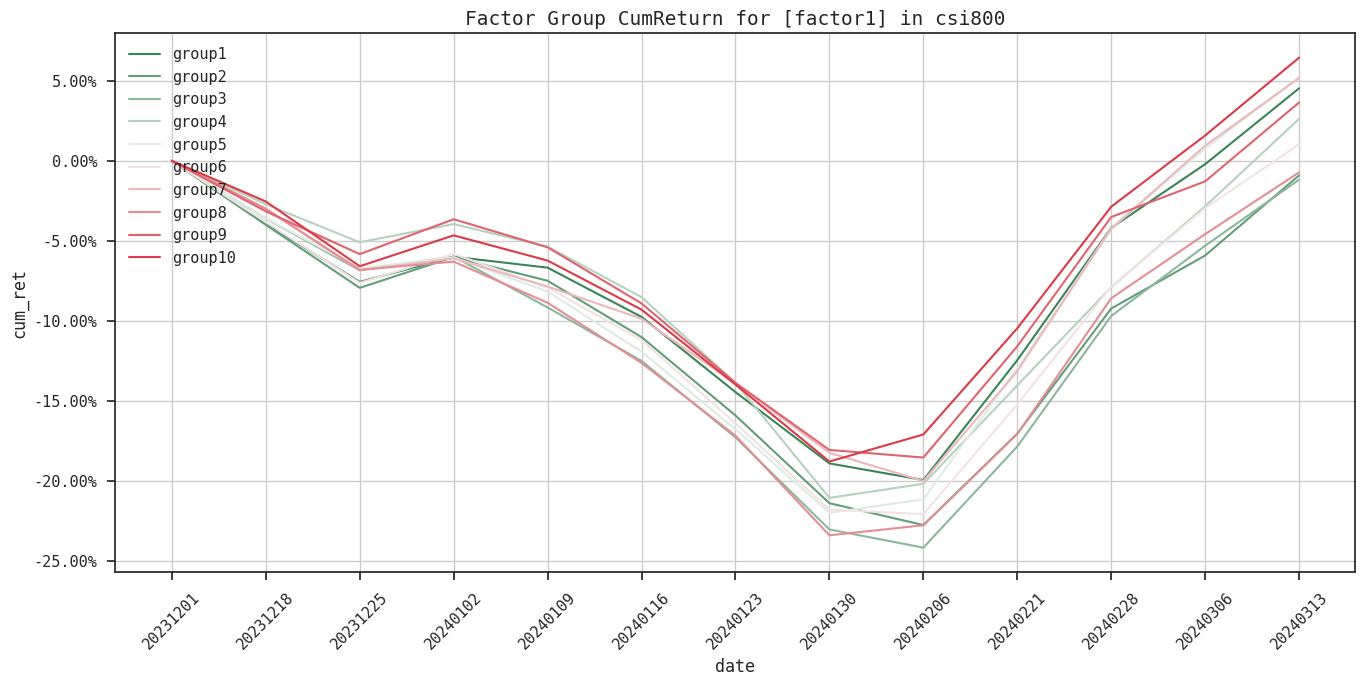

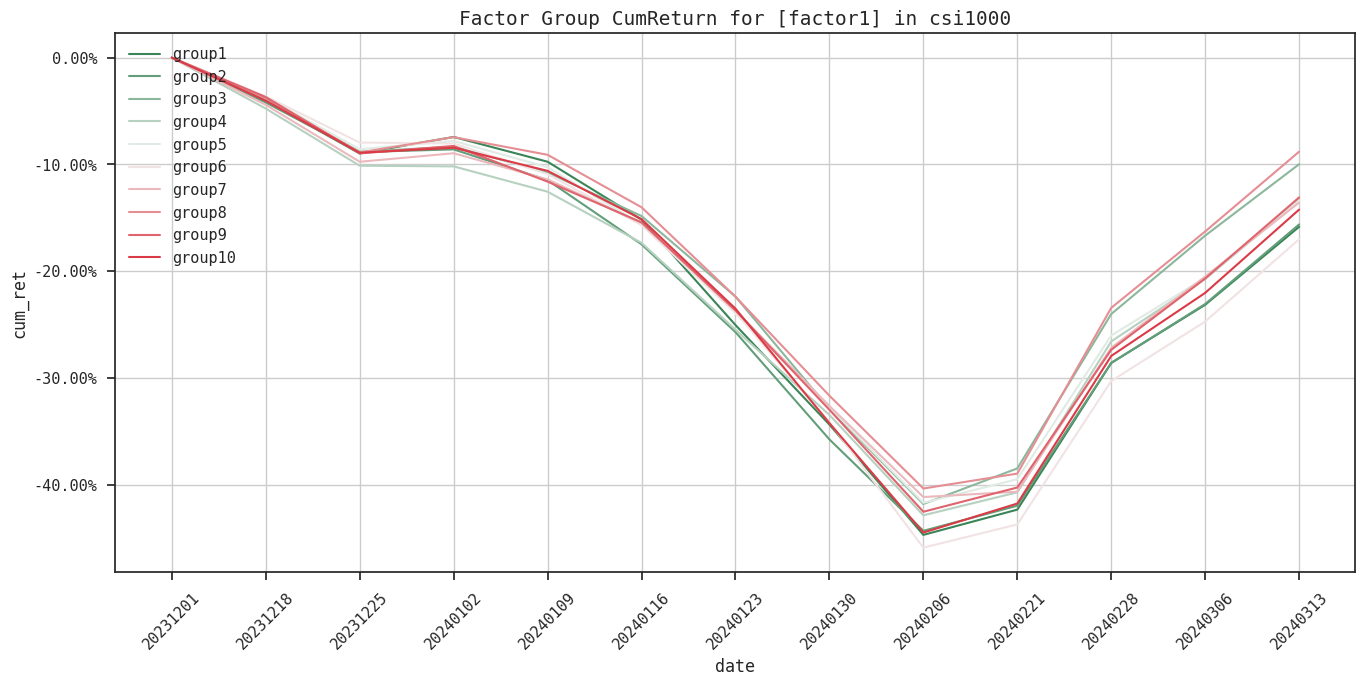

{'pnl_curve.factor1.csi300': <Figure size 1600x700 with 1 Axes>,
 'pnl_curve.factor1.csi500': <Figure size 1600x700 with 1 Axes>,
 'pnl_curve.factor1.csi800': <Figure size 1600x700 with 1 Axes>,
 'pnl_curve.factor1.csi1000': <Figure size 1600x700 with 1 Axes>,
 'grp_curve.factor1.csi300': <Figure size 1600x700 with 1 Axes>,
 'grp_curve.factor1.csi500': <Figure size 1600x700 with 1 Axes>,
 'grp_curve.factor1.csi800': <Figure size 1600x700 with 1 Axes>,
 'grp_curve.factor1.csi1000': <Figure size 1600x700 with 1 Axes>}

In [2]:
from src import api
rslt = api.perf_test()
rslt.display_figs()